In [1]:
%matplotlib inline
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

DATASET_PATH = './augmented/'

In [2]:
files = os.listdir(DATASET_PATH)

rawx=[]
rawy=[]
for file in files:
    img = cv2.imread(os.path.join(DATASET_PATH,file),cv2.IMREAD_GRAYSCALE)
    rawx.append(img)
    u = file.split('_')
    rawy.append(u[2])

In [3]:
im_h, im_w = rawx[0].shape
num_classes = len(np.unique(rawy))

In [4]:
x = np.asarray(rawx)
y = np.asarray(rawy)
x = x.reshape(len(files),im_h,im_w,1)
print(x.shape)
print(y.shape)

(5400, 50, 50, 1)
(5400,)


In [5]:
rawx= None
rawy= None

In [6]:
x = x / 255.


In [7]:
np.unique(y)

array(['0', '1', '2', '3', '4', '5'], dtype='<U1')

In [8]:
from sklearn.model_selection import train_test_split
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2,stratify=y)

In [9]:
x = None
y = None

In [10]:
def plot_6_images(xt,yt):
    
    idxs = [ random.randint(0,len(xt)) for i in range(0,6)]
    plt.figure(figsize=(10,5))
    for i in range(6):
        plt.subplot(2,3,i+1)
        plt.imshow(xt[idxs[i]].reshape(im_w,im_h),cmap='gray')
        plt.title('y={}'.format(yt[idxs[i]]))
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()  

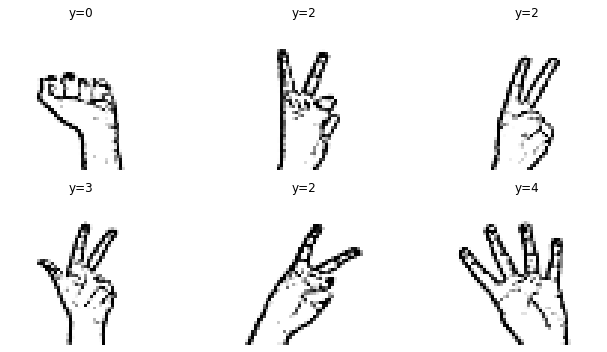

In [11]:
plot_6_images(xtrain,ytrain)

In [42]:
from keras.backend import clear_session

clear_session()
model = None

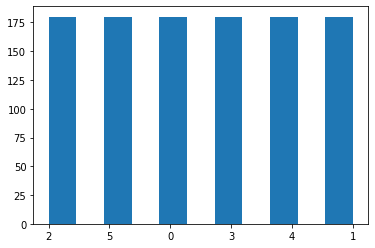

In [43]:
from keras.utils import to_categorical

ytrain_cat = to_categorical(ytrain, num_classes)
ytest_cat = to_categorical(ytest, num_classes)

plt.hist(ytest,bins=11);

In [44]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from keras.losses import categorical_crossentropy
from keras.optimizers import SGD, Adam, Adadelta
from keras.metrics import categorical_accuracy

model = Sequential()

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu',padding='valid', input_shape=(im_w,im_h,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3),padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3),padding='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.125))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=categorical_crossentropy,
              optimizer=Adadelta(),
              metrics=[categorical_accuracy])

print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 22, 22, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 11, 11, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 9, 9, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 128)        

In [45]:
# import tensorflow as tf
EPOC = 10
BS = 128

history = model.fit(xtrain, ytrain_cat, validation_split=0.2, batch_size=BS, epochs=EPOC)


Train on 3456 samples, validate on 864 samples
Epoch 1/10
3456/3456 [==============================] - 2s 523us/step - loss: 1.7793 - categorical_accuracy: 0.2674 - val_loss: 1.7324 - val_categorical_accuracy: 0.3438
Epoch 2/10
3456/3456 [==============================] - 1s 321us/step - loss: 1.1915 - categorical_accuracy: 0.6114 - val_loss: 0.7673 - val_categorical_accuracy: 0.7049
Epoch 3/10
3456/3456 [==============================] - 1s 330us/step - loss: 0.4900 - categorical_accuracy: 0.8325 - val_loss: 0.2429 - val_categorical_accuracy: 0.9132
Epoch 4/10
3456/3456 [==============================] - 1s 341us/step - loss: 0.1821 - categorical_accuracy: 0.9361 - val_loss: 0.0820 - val_categorical_accuracy: 0.9734
Epoch 5/10
3456/3456 [==============================] - 1s 347us/step - loss: 0.0776 - categorical_accuracy: 0.9740 - val_loss: 0.0554 - val_categorical_accuracy: 0.9850
Epoch 6/10
3456/3456 [==============================] - 1s 344us/step - loss: 0.0375 - categorical_accu

In [46]:
history.params

{'batch_size': 128,
 'epochs': 10,
 'steps': None,
 'samples': 3456,
 'verbose': 1,
 'do_validation': True,
 'metrics': ['loss',
  'categorical_accuracy',
  'val_loss',
  'val_categorical_accuracy']}

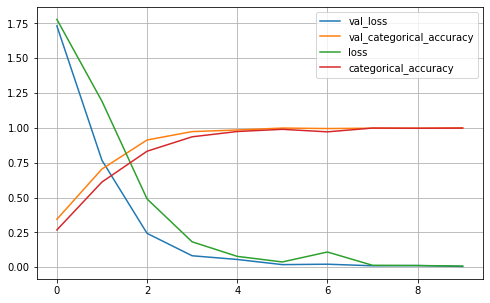

In [47]:
import pandas as pd
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca()
plt.show()

In [48]:
model.evaluate(xtest, ytest_cat)

1080/1080 [==============================] - 0s 283us/step


[0.0041683223710774825, 1.0]

In [49]:
import pandas as pd
ypred = model.predict_classes(xtest)

pd.crosstab(ytest, ypred, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,2,3,4,5,All
True,,,,,,,
0,180,0,0,0,0,0,180
1,0,180,0,0,0,0,180
2,0,0,180,0,0,0,180
3,0,0,0,180,0,0,180
4,0,0,0,0,180,0,180
5,0,0,0,0,0,180,180
All,180,180,180,180,180,180,1080


In [50]:
model.save('model_cnn.h5')

In [51]:
from keras.models import load_model
mymodel = load_model('model_cnn.h5')

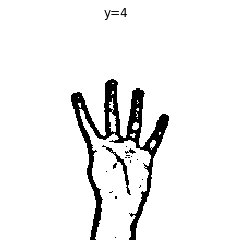

In [74]:
files = os.listdir('./originals/')
idx = random.randint(0,len(files))
origimg = cv2.imread('./originals/'+files[idx],cv2.IMREAD_GRAYSCALE)

myimg = origimg/255.
myimg = cv2.resize(myimg,(im_h, im_w))
myimg = myimg.reshape(1,im_h, im_w,1)

myclass = mymodel.predict(myimg)
pred = np.argmax(myclass)

plt.imshow(origimg, cmap='gray');
plt.title('y=%d' % pred);
plt.axis('off');
